In [79]:
import os
import sys
sys.path.insert(0, os.path.abspath(
    os.path.join(os.path.dirname('__file__'), '..')))

In [80]:
from src.encoding.encoders import *
from src.encoding.tools import create_encoding_pipeline
from src.models.sklearn_api_model import save_object, Model
from src.models.sklearn_api_models_config import get_model
from src.datasets.base_tabular_dataset import BaseTabularDataset
from src.experiments.base_experiment import BaseExperiment
import src.features as ft
import logging
import pandas as pd
import pathlib

In [81]:
# Define a logger used by all modules
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logging.basicConfig(level=logging.INFO, encoding="utf-8",
                    format="%(name)s %(asctime)s: %(levelname)s: %(message)s", handlers=[logging.StreamHandler()])

In [82]:
# Define the root directory of the project
root_dir = os.path.abspath(os.path.join(os.path.dirname('__file__'), '..'))
root_dir = pathlib.Path(root_dir)

In [83]:
# Define the configuration for the fetching of the data
fetch_config = {
    "data_start": '01-01-2019',
    "data_stop": '31-12-2023',
    'data_dir': root_dir / 'data',
    "locations": ['CHU Dijon'] #, 'CHU Besançon', 'CH Beaune', 'CH Semur', 'CH Chatillon Montbard', 'CH Chaumont', 'CH Langres', 'HNFC']
    }

In [84]:
# Select the features to be used in the dataset
ars_features_class = [
    ft.HospitalFeatures(include_emmergency_arrivals=False, include_nb_hospit=True),
    ft.AirQualityFeatures,
    ft.EpidemiologicalFeatures,
    # ft.FireFightersFeatures(include_calls=False),
    ft.GoogleTrendFeatures,
    ft.MeteorologicalFeatures,
    ft.SociologicalFeatures,
    ft.PopulationFeatures,
    ft.SportsCompetitionFeatures,
    ft.TrafficFeatures
    ]

In [85]:
# Select the target columns to be predicted
# target_colomns = ['nb_emmergencies']
target_colomns = ['nb_vers_hospit']
# target_colomns = ['nb_hospit_np_adults%%J+1%%mean_7J']

In [86]:
# Define an encoding scheme to create the encoding pipeline
encoders_dict = {
    'number': {
        'as_number': {
            'imputers': [imputers.SimpleImputer(strategy='mean')],
            'encoders': [
                ne.StandardScaler(),
            ]
        }
    },
    'category': {
        'as_category': {
            'imputers': [imputers.SimpleImputer(strategy='most_frequent')],
            'encoders': [
                ne.MultiTargetEncoder(drop_invariant=True, return_df=True),
            ]
        }
    },
    'datetime': {
        'as_number': {
            'imputers': [de.DateFeatureExtractor()],
            'encoders': [
                ne.CyclicalFeatures(drop_original=True)
            ]
        },
        'as_category': {
            'imputers': [de.DateFeatureExtractor(dtype='category')],
            'encoders': [
                ne.MultiTargetEncoder(drop_invariant=True, return_df=True),
            ]
        }
    },
    'boolean': {
        'as_number': {
            'imputers': [imputers.SimpleImputer(strategy='most_frequent')],
             'encoders': [ne.BooleanEncoder()]
         }

    }
}

In [87]:
# Create the encoding pipeline
pipeline = create_encoding_pipeline(encoders_dict)

Creating encoding pipeline


In [88]:
pipeline

ColumnTransformer(remainder='passthrough',
                  transformers=[('pipeline-1',
                                 Pipeline(steps=[('featureunion-1',
                                                  FeatureUnion(transformer_list=[('simpleimputer',
                                                                                  SimpleImputer())])),
                                                 ('featureunion-2',
                                                  FeatureUnion(transformer_list=[('standardscaler',
                                                                                  StandardScaler())]))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x13facd390>),
                                ('pipelin...
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x13faccfd0>),
                                ('pipeline-5',
                                 Pipeline(steps=[('featureunion-1',
                                                  FeatureUnion(transformer_list=[('simpleimputer',
                                                                                  SimpleImputer(strategy='most_frequent'))])),
                                                 ('featureunion-2',
                                                  FeatureUnion(transformer_list=[('booleanencoder',
                                                                                  BooleanEncoder())]))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x13facc9a0>)],
                  verbose=True)

In [89]:
# Define the splitting scheme to create the sets
split_config = {'test_size': 0.2, 'val_size': 0.2, 'shuffle': False}

In [90]:
features_config_get = {}

In [91]:
# Define the configuration of the dataset
dataset_config = {
    'from_date': '01-01-2019',
    'to_date': '30-12-2023',
    'locations': ['CHU Dijon'],
    # 'locations': ['CHU Dijon', 'CH Beaune', 'CH Semur', 'CH Chatillon Montbard', 'CH privé Dijon'],
    'axis': 'rows',
    'shift': range(1, 8, 1),
    'rolling_window': [7, 14, 31, 365],
    'freq': '1D',
    'split_config': split_config,
    'create_X_y': True,
    'encoding_pipeline': pipeline,
    'targets_names': target_colomns,
    'targets_shift': -7,
    'targets_rolling_window': 7,
    'targets_history_shifts': range(1, 8, 1),
    'targets_history_rolling_windows': [7, 14, 31, 365],
    'targets_locations': ['CHU Dijon'],
    'drop_constant_thr': 1.0,
    'data_dir': root_dir / 'data'
    #'target_bins': [0, 0.1, 0.3, 0.7, 0.9, 0.97, 1.0],
    # 'target_bins': [0, 0.3, 0.7, 1.0],
    #'replace_target': True,
    }

In [92]:
# Create the dataset and fetch the data from the source then call get_dataset() method to fill the different attributes (X and y) of the different sets, and their encodings
arsTabularDataset = BaseTabularDataset(features_classes=ars_features_class, logger=logger, fetch_config=fetch_config, getter_config=dataset_config)

root 2024-11-19 15:30:57,360: INFO: Initialisation de la classe BaseTabularDataset
root 2024-11-19 15:30:57,368: INFO: Initialisation des features
root 2024-11-19 15:30:57,370: INFO: Fetching dataset
hospitalfeatures 2024-11-19 15:30:57,644: INFO: hospitalfeatures's data already fetched for CHU Dijon
root 2024-11-19 15:30:57,823: INFO: airqualityfeatures's data already fetched for CHU Dijon
root 2024-11-19 15:30:58,018: INFO: epidemiologicalfeatures's data already fetched for CHU Dijon
root 2024-11-19 15:30:58,362: INFO: googletrendfeatures's data already fetched for CHU Dijon
root 2024-11-19 15:30:58,551: INFO: meteorologicalfeatures's data already fetched for CHU Dijon
root 2024-11-19 15:30:58,731: INFO: sociologicalfeatures's data already fetched for CHU Dijon
root 2024-11-19 15:30:58,942: INFO: populationfeatures's data already fetched for CHU Dijon
root 2024-11-19 15:30:59,158: INFO: sportscompetitionfeatures's data already fetched for CHU Dijon
root 2024-11-19 15:30:59,344: INFO:

Dropped 90 constant columns from both sets: {'NO2_FR26094', 'NO2_FR26010', 'PM10_FR26010', 'PM25_FR26094', 'PM10_FR26094', 'trend_épilepsie'}
X shape: (1155, 1800), y shape: (1155, 1)
[ColumnTransformer] .... (1 of 5) Processing pipeline-1, total=   0.1s
[ColumnTransformer] .... (2 of 5) Processing pipeline-2, total=   0.0s


root 2024-11-19 15:31:02,856: INFO: 63 features not encoded (same unit as target)


[ColumnTransformer] .... (3 of 5) Processing pipeline-3, total=   0.0s
[ColumnTransformer] .... (4 of 5) Processing pipeline-4, total=   0.1s
[ColumnTransformer] .... (5 of 5) Processing pipeline-5, total=   0.1s


In [93]:
df = arsTabularDataset.data

In [94]:
df

,trend_maladie%%J-6,trend_stress%%std_31J,Y30T34%%std_31J,trend_gastro-entérite%%std_7J,meteo_tavg%%J-6,Y90T94%%std_31J,Y15T19,trend_palpitations%%J-1,trend_infection respiratoire%%J-6,trend_migraines%%J-1,...,confinement2,trend_vertiges%%std_365J,Y10T14%%J-4,inc_varicelle%%std_365J,trend_hyperthermie%%mean_7J,Y65T69%%std_365J,trend_saignements%%std_365J,trend_asphyxie%%std_7J,Y5T9%%std_365J,confinement2%%J-6
date,,,,,,,,,,,,,,,,,,,,,
2019-01-07,0.0,0.000000,4.014490,0.0,5.9,4.303287,34555,0.0,0.0,0.0,...,False,3.192886,30608.0,136.399723,0.0,117.650044,3.768652,0.0,8.382737,False
2019-01-08,21.0,0.000000,4.014490,0.0,4.6,4.303287,34557,0.0,0.0,0.0,...,False,3.192886,30607.0,136.399723,0.0,117.650044,3.768652,0.0,8.382737,False
2019-01-09,52.0,0.000000,4.014490,0.0,1.3,4.303287,34559,0.0,0.0,0.0,...,False,3.192886,30607.0,136.399723,0.0,117.650044,3.768652,0.0,8.382737,False
2019-01-10,40.0,0.000000,4.014490,0.0,1.4,4.303287,34561,0.0,0.0,0.0,...,False,3.192886,30606.0,136.399723,0.0,117.650044,3.768652,0.0,8.382737,False
2019-01-11,43.0,0.000000,4.014490,0.0,3.2,4.303287,34563,0.0,0.0,0.0,...,False,3.192886,30606.0,136.399723,0.0,117.650044,3.768652,0.0,8.382737,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-12,52.0,2.155264,9.524614,0.0,4.3,5.635334,34572,0.0,0.0,0.0,...,False,9.054539,30206.0,276.285752,0.0,35.132234,3.611625,0.0,90.952115,False
2023-12-13,64.0,2.155264,9.531837,0.0,0.3,5.646200,34571,0.0,0.0,0.0,...,False,9.054539,30206.0,276.332084,0.0,35.172217,3.611625,0.0,91.015697,False
2023-12-14,64.0,2.155264,9.535446,0.0,6.1,5.642389,34571,0.0,0.0,0.0,...,False,9.054539,30205.0,276.378173,0.0,35.209376,3.611625,0.0,91.076440,False


In [95]:
df[target_colomns]

,nb_vers_hospit
date,
2019-01-07,46
2019-01-08,57
2019-01-09,40
2019-01-10,48
2019-01-11,60
...,...
2023-12-12,38
2023-12-13,42
2023-12-14,37


In [96]:
# arsTabularDataset.enc_data.to_csv('enc_data_hospit.csv')
# arsTabularDataset.data['nb_vers_hospit'].to_csv('target_hospit.csv')

In [62]:
from pmdarima import auto_arima

# Recherche des meilleurs paramètres ARIMA
modele_auto = auto_arima(df[target_colomns], seasonal=False, trace=True, error_action='ignore', suppress_warnings=True)
print(modele_auto.summary())

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=12183.404, Time=0.65 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=18528.675, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=13323.959, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=16749.911, Time=0.10 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=12187.769, Time=0.13 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=12189.649, Time=0.33 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=12179.872, Time=0.55 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=12178.279, Time=0.37 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=0.17 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=12179.716, Time=0.46 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=inf, Time=0.24 sec
 ARIMA(4,0,2)(0,0,0)[0]             : AIC=12182.279, Time=0.52 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=12166.815, Time=1.46 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   :

In [64]:
import numpy as np
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
import warnings; warnings.simplefilter('ignore')
from sklearn.metrics import mean_absolute_error, mean_squared_error

cible = []


N = 50
for k in range(N):
    serie = df[target_colomns][:(-(N+15)+k)]


    # Définir le modèle ARMA (p, q à ajuster selon votre série temporelle)
    #p, d, q =4,1,3
    modele = ARIMA(serie, order=(4, 0, 1), enforce_stationarity=False, enforce_invertibility=False)
    modele_fit = modele.fit()

    # modele = SARIMAX(serie, order=(4, 0, 1), seasonal_order=(1, 1, 0, 7))
    # modele_fit = modele.fit(disp=False)


    # Ajuster le modèle
    #modele_fit = modele.fit(method_kwargs={"disp": 0})

    # Prédiction des 15 prochains jours
    pas_prevision = 15
    prevision = modele_fit.forecast(steps=pas_prevision)

    # Affichage des résultats
    print(k, prevision.iloc[-1])
    cible.append(prevision.iloc[-1])

0 37.84106132008156
1 38.20066201457605
2 38.000668351176735
3 37.10743247722438
4 37.05623805547299
5 37.69805887109472
6 37.658743819924226
7 38.422531223095405
8 38.14172966286281
9 38.084256746071006
10 37.95392324348048
11 37.96147345015875
12 37.514380953732726
13 38.41259968592268
14 38.50310052057428
15 38.442423885117535
16 36.87636787700028
17 36.34462540358186
18 37.38710475516931
19 37.19936521337613
20 37.50901071994541
21 38.59664192673493
22 39.38378921546135
23 39.273162828230454
24 38.74916766531266
25 38.570743325089616
26 38.911885683541804
27 38.17874546551785
28 38.88939773077919
29 39.24006326236825
30 38.986898480127856
31 38.02843993157106
32 38.84171014812154
33 38.6539228841948
34 38.928218146224744
35 38.89042685150801
36 39.52588225837766
37 39.37460665928167
38 38.5086687276612
39 38.802527643458035
40 37.92515093749384
41 38.8475935686761
42 38.47013707949749
43 39.86003933912906
44 40.04234680574031
45 40.17390914489655
46 39.78313572847156
47 39.97157342

In [21]:
mean_absolute_error(cible, list(df[target_colomns][-N:].values))

6.126747458319455

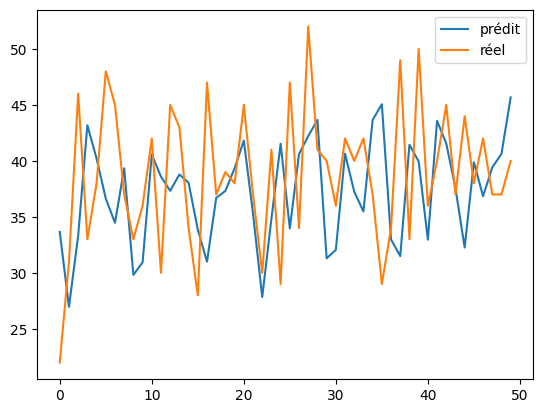

In [23]:
plt.plot(cible, label='prédit')
plt.plot(list(df[target_colomns][-N:].values), label='réel')
plt.legend()

In [97]:
# print(arsTabularDataset.data.columns.to_list())
# Define the model parameters
model_params = {
    
    'early_stopping_rounds': 10,
    # 'eval_set': [(arsTabularDataset.enc_X_val, arsTabularDataset.y_val)], # TODO: to be set in the experiment's run method
    'verbosity': 0,
    'n_estimators': 10000,
    'learning_rate': 0.1,
    'min_child_weight': 5,
    # 'multi_strategy': 'one_output_per_tree',
    # 'multi_strategy': 'multi_output_tree' 
}

In [98]:
metrics = ['w_rmse', 'pw_rmse', 'rmse', 'mae', 'mse'] # first one is used for evaluation and everywhere a sinlge metric is used, the rest are used for testing
# metrics = ['']

In [99]:
# Create the model
model = get_model(model_type='xgboost', name='XGBoost', device='cpu', task_type='regression', test_metrics=metrics, params=model_params)

rmse


In [100]:
# Create the experiment
ars_experiment = BaseExperiment(logger=logger, dataset=arsTabularDataset, model=model)

2024/11/19 15:32:05 INFO mlflow.tracking.fluent: Experiment with name 'target_nb_vers_hospit_CHU Dijon%%J+7%%mean_7J' does not exist. Creating a new experiment.


In [101]:
# Set the model fitting config
grid_params = {
    'max_depth': [3, 5, 7, 9, 11],
}

In [102]:
fit_params = {
    'verbose': 0,
}

In [103]:
model_config={"optimization": "grid", "grid_params": grid_params, "fit_params": fit_params}

In [ ]:
# Run the experiment
ars_experiment.run(dataset_config=dataset_config, model_config=model_config, find_best_features=True, int_pred=False, balance_target=False)

2024/11/19 15:32:14 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
2024/11/19 15:32:14 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
root 2024-11-19 15:32:14,638: INFO: Running the experiment...
root 2024-11-19 15:32:16,012: INFO: Features selected: ['nb_emmergencies%%J-7', 'nb_emmergencies%%J-1', 'nb_emmergencies%%J-2', 'nb_emmergencies%%J-3', 'nb_emmergencies', 'NO2_FR26094%%mean_7J', 'nb_emmergencies%%mean_365J', 'eveBankHolidays', 'meteo_wdir%%J-7', 'confinement1', 'trend_grippe%%mean_7J', 'trend_hopital%%J-3', 'trend_vaccin%%J-2', 'inc_diarrhee%%J-7', 'PM25_FR26094%%J-7', 'trend_crampes abdominales%%J-7', 'trend_médecin', 'trend_crampes abdominales%%mean_7J', 'confinement2', 'NO2_FR26010', 'trend_hopital%%J-2', 'trend_mal de tête%%mean_7J', 'trend_paralysie%%J-7', 'trend_accident

Dropped 3 constant columns from both sets: {'PM25_FR26094', 'NO2_FR26094', 'NO2_FR26010'}
X shape: (1155, 21), y shape: (1155, 1)
[ColumnTransformer] .... (1 of 3) Processing pipeline-1, total=   0.0s
[ColumnTransformer] .... (2 of 3) Processing pipeline-2, total=   0.0s
[ColumnTransformer] .... (3 of 3) Processing pipeline-5, total=   0.0s


ValueError: Invalid artifact file path 'datasets/full_dataset_feature_selection.csv'. Please ensure the file you are trying to log as a table has a file name with either '.json' or '.parquet' extension.